In [1]:
from bs4 import BeautifulSoup
import requests
import re
import pandas as pd
import pickle
import datetime as dt
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import lxml

### 00_All_Data_Jobs

With the initial analysis on filtering, I'm going to expand the data set from `Data+Scientist` to include more jobs in the same job family:
- Data+Scientist
- Data+Analyst
- Data+Engineer
- Machine+Learning

In [6]:
# link to the scrap 
# Data+Scientist, Data+Analyst, Data+Engineer, Machine+Learning

links = [
    'https://h1bdata.info/index.php?em=&job=Data+Scientist&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Scientist+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Analyst&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Analyst+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Engineer&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Data+Engineer+&city=&year=All+Years',
    'https://h1bdata.info/index.php?em=&job=Machine+Learning+&city=&year=All+Years'
]

jobs_list = []
for link in links:
    page_link = link
    page_response = requests.get(page_link, timeout=1000)
    page_content = BeautifulSoup(page_response.content, 'lxml')

    for row in page_content.find_all('tr')[1:]:
        row_data = []
        for i in row:
            row_data.append(i.text)
        jobs_list.append(row_data)

len(jobs_list)

28101

### 01_Create_Table

Store the list in a table for analysis.

In [16]:
# Put everything into dataframes for easier processing

ds_jobs_df = pd.DataFrame()
ds_jobs_df['company'] = [i[0] for i in jobs_list]
ds_jobs_df['title'] = [i[1] for i in jobs_list]

ds_jobs_df['salary'] = [i[2].replace(',','') for i in jobs_list]
ds_jobs_df['salary'] = ds_jobs_df['salary'].astype(float)

ds_jobs_df['location'] = [i[3] for i in jobs_list]

ds_jobs_df['date'] = [i[4] for i in jobs_list]
ds_jobs_df['date'] = pd.to_datetime(ds_jobs_df['date'])
ds_jobs_df['year'] = [i.year for i in ds_jobs_df['date']]

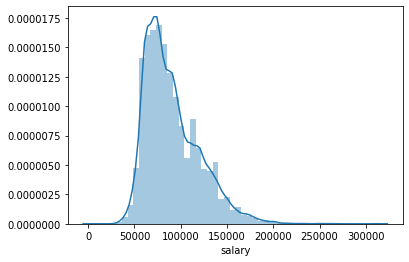

In [9]:
# initial view on new distribution

sns.distplot(ds_jobs_df[ds_jobs_df['salary']<400000]['salary'])

### 02_Outliners

Take a look at top and bottom of the dataframe.

In [10]:
ds_jobs_df.sort_values(by=["salary"], ascending=False).head(10)

,company,title,salary,location,date,year
7343,AIRBNB INC,DATA SCIENTIST,1350001.0,"SAN FRANCISCO, CA",2015-02-12,2015
20699,ANTRA INC,DATA ANALYST,847000.0,"WASHINGTON, DC",2019-05-07,2019
13956,ANTRA INC,DATA ANALYST,847000.0,"WASHINGTON, DC",2019-05-07,2019
170,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-03-21,2018
171,LARSON LIVING LABS LLC,DATA SCIENTIST,312000.0,"CAMBRIDGE, MA",2018-05-14,2018
27112,FACEBOOK INC,MACHINE LEARNING ACCELERATOR IMPLEMENTATION TE...,270000.0,"MENLO PARK, CA",2019-03-22,2019
25974,PRO US-CW,DATA ENGINEER,265200.0,"MENLO PARK, CA",2019-08-07,2019
7341,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-04-09,2019
7340,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2018-12-10,2018
7342,STITCH FIX INC,DATA SCIENTIST,260000.0,"SAN FRANCISCO, CA",2019-05-24,2019


In [11]:
ds_jobs_df.sort_values(by=["salary"], ascending=True).head(10)

,company,title,salary,location,date,year
172,THREATMETRIX INC,DATA SCIENTIST,5769.0,"SAN JOSE, CA",2015-01-06,2015
173,DOMINION ENTERPRISES,DATA SCIENTIST,29973.0,"NORFOLK, VA",2016-03-01,2016
13974,SUMMIT ENERGY SERVICES INC,DATA ANALYSIS ASSOCIATE,31574.0,"LOUISVILLE, KY",2015-03-20,2015
7344,NYC METRO REGIONAL CENTER LLC,DATA ANALYST,33380.0,"FLUSHING, NY",2016-03-24,2016
14087,NYC METRO REGIONAL CENTER LLC,DATA ANALYST,33380.0,"FLUSHING, NY",2016-03-24,2016
7923,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7924,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
14667,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7925,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017
7926,INSTITUTE FOR TRUTH IN ACCOUNTING,DATA ANALYST,34050.0,"CHICAGO, IL",2017-03-22,2017


In [12]:
# data_by_year
ds_jobs_df[["year","title"]].groupby(["year"]).count()

,title
year,
2012,5
2013,13
2014,294
2015,2721
2016,4999
2017,5212
2018,7022
2019,7835


Looks like the exclusion criteria we came up from previous analysis is still relevant.

In [17]:
# Excluding Outliners

# Drop pre 2014 data (very few observations pre 2014)
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['year']<=2014].index, axis=0, inplace=True)

# Drop salaries over $400,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']>400000].index, axis=0, inplace=True)

# Drop salaries lower than $200,000
ds_jobs_df.drop(ds_jobs_df[ds_jobs_df['salary']<20000].index, axis=0, inplace=True)

# Sort by company and year
ds_jobs_df.sort_values(by=['year','company'], inplace=True, ascending=True)

In [18]:
ds_jobs_df.shape # population drops from 28,101 to 27,785 after exclusion

(27785, 6)

### 03_Job_Families

This time I included all the job titles containing the key words. To get some meaningful analysis I need to group them in a meaningful way to distinguish the different job titles I use for analysis.

In [32]:
ds_jobs_df[["title","salary"]].groupby(["title"]).size().nlargest(15).reset_index(name='top15')

,title,top15
0,DATA ANALYST,13062
1,DATA SCIENTIST,7266
2,DATA ENGINEER,2894
3,DATA ANALYST 2,841
4,DATA ENGINEER II,577
5,MACHINE LEARNING ENGINEER,555
6,DATA ANALYST 3,317
7,DATA ENGINEER I,167
8,DATA ANALYST II,155
9,DATA ENGINEER III,120


Next, create a new column to group these job families into 5 categories:
- Data Scientist
- Data Analyst
- Data Engineer
- MACHINE LEARNING ENGINEER
- Manager 

In [31]:
ds_jobs_df['salary'].median()

84140.0